## Importing Essentials

In [ ]:
!pip install pandas tensorflow stopwords nltk gensim

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
# Tensorflow NLP kit(only so much for our needs)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Classification metric
from sklearn.metrics import classification_report

In [ ]:
# NLTK NLP kit(only so much for our needs)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import zipfile
# with zipfile.ZipFile('/content/drive/MyDrive/ADHD/trainingandtestdata.zip', 'r') as zip_ref:
#   zip_ref.extractall('/content')

In [ ]:
columns = ["target", "ids", "date", "flag", "user", "text"]
training_data = pd.read_csv('/content/drive/My Drive/ADHD/training.1600000.processed.noemoticon.csv', encoding='latin_1', names=columns)
testing_data = pd.read_csv('/content/drive/My Drive/ADHD/testdata.manual.2009.06.14.csv', encoding='latin_1', names=columns)
training_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Cleaning the data/ Preprocessing

In [ ]:
print(stopwords.words('english'))
emoticons = [":)", ':-)', ': )', ':D', '=)', ':(', ':-(', ': (']
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(emoticons)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
print(stpwrd)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
import re # import regex

def preprocess_data(data):
  data = data.drop_duplicates(subset=['text'], keep='first')

  # Remove emojis from data
  data = data.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

  # Remove emoticons as stopwords so it will happen when tokenizing our sentences hence not needed here

  # Remove urls
  def remove_username_link_nums(text):
    text = re.sub('@[^\s]+', '', text)
    text = re.sub('http[^\s]+', '', text)
    text = re.sub(r'\d+', '', text)
    return text

  data['text'] = data['text'].apply(remove_username_link_nums)

  # # turn text to lowercase
  data['text'] = data['text'].map(lambda x: x.lower())

  # Remove stopwords and lemmatize the text
  lem = WordNetLemmatizer()
  def remove_stopwords(text):
    tokens = []
    for token in text.split():
      if token not in stpwrd:
        tokens.append(lem.lemmatize(token, "v"))

    return  " ".join(tokens)

  data.text = data.text.apply(lambda x: remove_stopwords(x))


  return data


## Analysing our main data
It is essential that we take a look at the data we're finally going to use for building our model.
We'll also divide our data into testing and training data without wasting any more time.

In [ ]:
train_neg = training_data[:10000]
train_pos = training_data[1590000:]


In [ ]:
test_neg = training_data[10000:12000]
test_pos = training_data[1588000:1590000]

In [ ]:
test_neg = preprocess_data(test_neg.drop(['ids', 'date', 'flag', 'user'], axis=1))
test_pos = preprocess_data(test_pos.drop(['ids', 'date', 'flag', 'user'], axis=1))
train_neg = preprocess_data(train_neg.drop(['ids', 'date', 'flag', 'user'], axis=1))
train_pos = preprocess_data(train_pos.drop(['ids', 'date', 'flag', 'user'], axis=1))

In [ ]:
train_neg.shape

(9976, 2)

In [ ]:
train_examples =pd.concat([train_neg, train_pos])
test_examples =pd.concat([test_neg, test_pos])

In [ ]:
train_examples.shape

(19955, 2)

In [ ]:
test_examples.shape

(3996, 2)

In [ ]:
# Fix : The following code would run without any error but with new update of nltk, wordprocessng not done without omw
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
train_data = preprocess_data(training_data.drop(['ids', 'date', 'flag', 'user'], axis=1))
test_data = preprocess_data(testing_data.drop(['ids', 'date', 'flag', 'user'], axis=1))

train_data.head()

,target,text
0,0,"- awww, that's bummer. shoulda get david carr ..."
1,0,upset can't update facebook texting it... migh...
2,0,dive many time ball. manage save % rest go bound
3,0,whole body feel itchy like fire
4,0,"no, behave all. i'm mad. here? can't see there."


In [ ]:
# taking care of missing data
train_data.isna().sum().sort_values()
# since no data is missing, let's move on with the workflow

target    0
text      0
dtype: int64

In [ ]:
print(train_examples.groupby('target').size())

target
0    9976
4    9979
dtype: int64


In [ ]:
print(test_examples.groupby('target').size())

target
0    1996
4    2000
dtype: int64


In [ ]:
print(test_examples.groupby('target').size())

target
0    1996
4    2000
dtype: int64


In [ ]:
print(f"Shape of training data : {train_data.shape}")

Shape of training data : (1581466, 2)


In [ ]:
train_examples.shape

(19955, 2)

## Start tokenizing our tweets!
We're done organizing our data.
The next task is to tokenize our data to make to "assign meaning to words".
Tokenization is where the actual nlp begins i.e. step no. 1.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_examples.text)


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_examples.text)
test_sequences = tokenizer.texts_to_sequences(test_examples.text)

X_train = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

X_test = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
len(word_index)

18991

In [ ]:
X_train.shape

(19955, 50)

In [ ]:
test_data.head()

,target,text
0,4,"loooooooovvvvvveee kindle. dx cool, fantastic ..."
1,4,read kindle... love it... lee childs good read.
2,4,"ok, first assesment #kindle ...it fuck rocks!!!"
3,4,love kindle. i've mine months never look back....
4,4,fair enough. kindle think perfect


In [ ]:
y_train = train_examples.target.replace({'0': 0, '4' : 1}).values
y_test = test_examples.target.replace({'0': 0, '4' : 1, '2':1}).values

In [ ]:
y_test.dtype

dtype('int64')

In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Word2Vec
Word2vec is a technique for NLP. This algorithm uses a neural network model to learn word associations. This may also be called word embedding in various texts.
For our purpose and to make the project easy, we will make use of Gensim, which will help us to develop word embeddings.

In [ ]:
# Word2Vec
import gensim

# WORD2VEC
W2V_SIZE = 228
W2V_WINDOW = 7
W2V_EPOCH = 10
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in train_examples.text]
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1868


In [ ]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(869814, 1491990)

In [ ]:
w2v_model.wv.most_similar("laugh")

[('character', 0.9988815188407898),
 ('miley', 0.9988310933113098),
 ('coach', 0.9988216161727905),
 ('agree', 0.9987519979476929),
 ('truly', 0.9987363219261169),
 ('area', 0.9987273216247559),
 ('luv', 0.9987252354621887),
 ('twitter!', 0.9987179636955261),
 ('save', 0.9987000823020935),
 ('congrats', 0.9986937046051025)]

In [ ]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(1869, 228)


## Building our NLP model using LSTM
LSTM (Long short-term memory) are special kinds of RNN, these are  designed to have a long-term memory making them capable of understanding the context better.
Will these help us understand the context or sentiment of our tweets better, or not?
There are previously many models built using different algorithms; let's see if using LSTMs make a staggering difference.

In [ ]:
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=max_length, trainable=False),
                                      tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Bidirectional(LSTM(128)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')

], name='Bidirectional_LSTM_1')

model_1.summary()

Model: "Bidirectional_LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 228)           426132    
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           365568    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)       

In [ ]:
test_data.dtypes

target    object
text      object
dtype: object

In [ ]:
model_1.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

history = model_1.fit(X_train, y_train, batch_size = 32, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
624/624 [==============================] - 23s 19ms/step - loss: 0.6608 - accuracy: 0.5970 - val_loss: 0.6481 - val_accuracy: 0.6169
Epoch 2/50
624/624 [==============================] - 9s 14ms/step - loss: 0.6416 - accuracy: 0.6276 - val_loss: 0.6326 - val_accuracy: 0.6384
Epoch 3/50
624/624 [==============================] - 12s 19ms/step - loss: 0.6350 - accuracy: 0.6326 - val_loss: 0.6556 - val_accuracy: 0.6209
Epoch 4/50
624/624 [==============================] - 11s 17ms/step - loss: 0.6269 - accuracy: 0.6416 - val_loss: 0.6231 - val_accuracy: 0.6411
Epoch 5/50
624/624 [==============================] - 9s 14ms/step - loss: 0.6207 - accuracy: 0.6455 - val_loss: 0.6207 - val_accuracy: 0.6451
Epoch 6/50
624/624 [==============================] - 11s 17ms/step - loss: 0.6153 - accuracy: 0.6519 - val_loss: 0.6173 - val_accuracy: 0.6524
Epoch 7/50
624/624 [==============================] - 10s 16ms/step - loss: 0.6112 - accuracy: 0.6570 - val_loss: 0.6290 - val_accuracy: 0

In [ ]:
y_pred = model_1.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

125/125 [==============================] - 2s 6ms/step


## Computational limitations
This project was built with zero monetary investment. The model performed with over an accuracy of 83% which is not much but the sample size taken was very small and the complexity of the RNN was very simple to make this model work fast. Training time ~ 10 mins for word vector, and RNN combined. This could have performed better with a better GPU and memory investment.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65      1996
           1       0.65      0.62      0.63      2000

    accuracy                           0.64      3996
   macro avg       0.64      0.64      0.64      3996
weighted avg       0.64      0.64      0.64      3996



In [ ]:
model_1.save('Sentiment_LSTM_model.h5')
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model_1 = load_model('Sentiment_LSTM_model.h5')
# loading tokenizer
with open('trainHistoryDict', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [ ]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

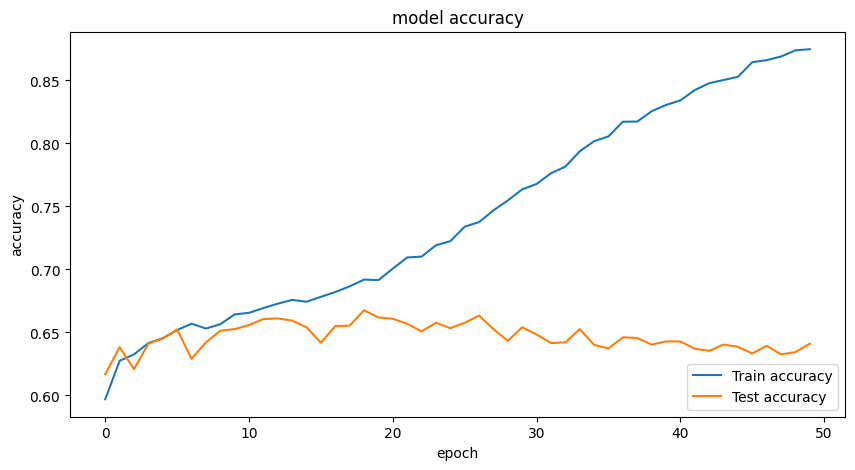

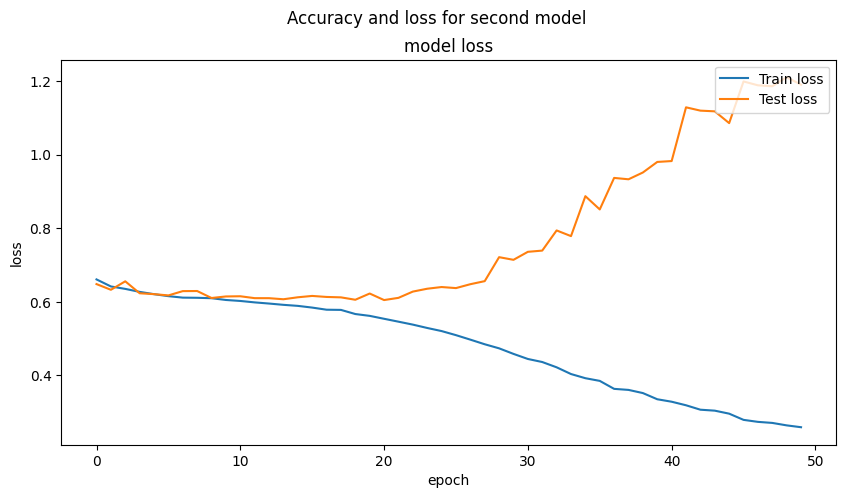

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

In [ ]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_length)
    # Predict
    score = model_1.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score >=0.4):
        label = "Negative"
    if(score <=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)}

In [ ]:
predict(" i love everyone")

1/1 [==============================] - 2s 2s/step


<ipython-input-54-0ebfdffa5e73>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Positive', 'score': 0.5773854851722717}

In [ ]:
predict(" i hate twitter")

1/1 [==============================] - 0s 21ms/step


<ipython-input-54-0ebfdffa5e73>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Positive', 'score': 0.5642890334129333}

In [ ]:
predict("it is good to show love")

1/1 [==============================] - 0s 21ms/step


<ipython-input-54-0ebfdffa5e73>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Negative', 'score': 0.7082274556159973}

In [ ]:
predict("I love how idiots are never killed in movies")

1/1 [==============================] - 0s 23ms/step


<ipython-input-54-0ebfdffa5e73>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Positive', 'score': 0.5877389907836914}